## Final Assignment

#### Imports

In [672]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
from  datetime import datetime
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.inspection import permutation_importance


#### 2. Get the data

The following dataset is a combination of many sets from different sources found online, as it was difficult to find one dataset that would be comprehensive enough for the scale of the assignment. After a thorough research, we asked ChatGPT to combine all the information into one table and group it based on the Holmes typology. In case of missing data, certain values were added manually.

In [673]:
# Loading the data
df = pd.read_excel('SerialKiller_Dataset.xlsx')
df

,Name,Birthday,Countries Active,Years Active,Proven Victims,Possible Victims,BirthYear,StartYear,Age At The Start of Killing,Notes,Type,Nickname,Reason,Archetype/Classification,Gender,Victim Age,Victim Gender,Targeted Group Type
0,Ray Copeland,12/30/1914,United States,1986-1989,5,12,1914.0,1986.0,72.0,Ray Copeland is an American serial killer who ...,Unknown,NaN,Power,Power/Control,Male,Adult,Mixed,NaN
1,Faye Copeland,1921-04-08 00:00:00,United States,1986-1989,5,12,1921.0,1986.0,65.0,Faye Copeland (born Faye Della Wilson) is an A...,Unknown,NaN,Power,Power/Control,Female,Adult,Mixed,NaN
2,Salvatore Perrone,11/22/1948,United States,2012,3,3,1948.0,2012.0,64.0,A failing business owner and former door-to-do...,Unknown,"The Son of Sal, John Doe Duffel Bags_x000D_\n",Power,Power/Control,Male,Adult,Male,NaN
3,Viktor Fokin,2/19/1935,Russia,1996-2000,9,10+,1935.0,1996.0,61.0,"Pensioner who lured, killed and then dismember...",Hate Crime,Grandfather Ripper,Hate Crime,Mission-Oriented (Hate-Crime/Targeted Groups),Male,Adult,Female,NaN
4,Andr??Â?s P??Â?ndy,1927-01-06 00:00:00,Belgium,1986-1990,6,14+,1927.0,1986.0,59.0,"Former clergyman, killed his two wives and fou...",Unknown,Father Bluebeard,Power,Power/Control,Male,Child,Male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,Süleyman Aktaş,NaN,Turkey,1986-1994,5,5,NaN,1986.0,NaN,"In 1986, he killed police superintendent Nuri...","Hate Crime, Stangler",The Nailing Killer,Thrill,Hedonistic,Male,Adult,Male,Elderly
635,Valery Asratyan,NaN,Russia,1988-1990,3,3,NaN,1988.0,NaN,During Valery Asratyan's crimes as a serial ki...,"Financial Motive, Rapist, Sexual Predator",The Director,"Financial Gain, Sexual Assault",Hedonistic,Male,Adult,Female,NaN
636,Dmitry Baksheev,NaN,Russia,1999-2017,1,30,NaN,1999.0,NaN,"Dmitry Baksheev, and his wife Natalia Baksheev...",Cannibal,Cannibal Couple,Cannibalism,Hedonistic,Male,Adult,Female,NaN
637,Natalia Baksheev,NaN,Russia,1999-2017,1,30,NaN,1999.0,NaN,"Natalia Baksheev, and her husband Dmitry Baksh...",Cannibal,Cannibal Couple,Cannibalism,Hedonistic,Female,Adult,Female,NaN


##### Checking the size and type of data

The df.info() method was used in order to check the size and types of data in our dataset. It shows the number of entries (rows), as well as the number of columns, non-null values and the types of values in each of the columns.

In [674]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         639 non-null    object 
 1   Birthday                     539 non-null    object 
 2   Countries Active             639 non-null    object 
 3   Years Active                 639 non-null    object 
 4   Proven Victims               639 non-null    object 
 5   Possible Victims             577 non-null    object 
 6   BirthYear                    575 non-null    float64
 7   StartYear                    627 non-null    float64
 8   Age At The Start of Killing  560 non-null    float64
 9   Notes                        632 non-null    object 
 10  Type                         639 non-null    object 
 11  Nickname                     431 non-null    object 
 12  Reason                       639 non-null    object 
 13  Archetype/Classifica

From the names and types of columns, we inferred that it would make sense to check for outliers in the numeric data, such as BirthYear, StartYear and Age At the Start of Killing (which was calculated using StartYear-BirthYear). 

### 3. Explore the data

#### Studying features

In [675]:
# Creating a copy of the data
df_copy = df

# Assesing the unique values in the columns to understand the data
for column in df_copy.columns:
    missing_count = df_copy[column].isnull().sum()
    data_type = df_copy[column].unique()
    print(f"{column}: {missing_count} missing values, Data Type: {data_type}")

Name: 0 missing values, Data Type: ['Ray Copeland' 'Faye Copeland' 'Salvatore Perrone' 'Viktor Fokin'
 'Andr??Â?s P??Â?ndy' 'Gary Hilton' 'Hubert Pilcik' 'Bruce McArthur'
 'John Wayne Glover' 'Hubert Pil?„ÂŤ??Â\xadk' 'Charles Albright'
 'Bruce Mendenhall' 'Marie Alexandrine Becker' 'Albert Fish'
 'Dorothea Puente' 'Archibald Hall' 'Elfriede Blauensteiner'
 'Vasili Komaroff' 'David Carpenter' 'Anthony Hardy' 'Elisabeth Wiese'
 'Juan D??Â\xadaz de Garayo' 'Tamara Samsonova' 'Anthony Sowell'
 'Steve Wright' 'Leonard Fraser' 'Ramon Escobar'
 'Henri D??Â©sir??Â© Landru' 'Ivan Milat' 'Donato Bilancia'
 'Jose Rodriguez' 'Michel Fourniret' 'Peter Tobin' 'Leonarda Cianciulli'
 'William Clyde Gibson' 'Martin Dumollard' 'Robert Ben Rhoades'
 'Daniel Camargo Barbosa' 'John Christie' 'Billy Chemirmir' 'Bandali Debs'
 'Peter Dupas' 'Edward Edwards' 'Herb Baumeister' 'Angelo Buono Jr.'
 'Joseph Naso' 'Billy Glaze' 'Adam Leroy Lane' 'William Neal'
 'L??Â©opold Dion' 'Javed Iqbal' 'Andrei Chikatilo' 'M

Fixing the country column to have real countries 

In [676]:
def clean_countries(country_str):
    # Remove special characters and normalize
    country_str = country_str.replace('?‚Â\xa0', ',').replace('\xa0', ',')
    
    # Country name mappings
    country_map = {
        'Austrailia': 'Australia',
        'Soviet Union': 'Russia',
        'German Empire': 'Germany',
        'Weimar Republic': 'Germany',
        'Nazi Germany': 'Germany',
        'West Germany': 'Germany',
        'Kingdom of Italy': 'Italy',
        'Ottoman Empire': 'Turkey',
        'Persia': 'Iran',
        'Allied-occupied Germany': 'Germany',
        'Czechoslovakia': 'Czech Republic',
        'Yugoslavia': 'Serbia',
        'Swaziland': 'Eswatini'
    }
    
    # Clean and split countries
    countries = []
    for country in country_str.split(','):
        # Clean the country name
        country = country.strip()
        country = country.split('(')[0].strip()  # Remove parenthetical notes
        country = country.replace('?', '').strip()
        
        # Apply mapping if exists
        country = country_map.get(country, country)
        
        if country and country not in countries:
            countries.append(country)
    
    return ', '.join(sorted(countries))

# Apply the cleaning function
df_copy['Countries Active'] = df_copy['Countries Active'].apply(clean_countries)

# Verify results
print("Unique countries after cleaning:")
print(sorted(df_copy['Countries Active'].unique()))

Unique countries after cleaning:
['Afghanistan', 'Argentina', 'Australia', 'Austria', 'Austria, Czech Republic, United States', 'Bangladesh', 'Belarus', 'Belgium', 'Belgium, France', 'Brazil', 'Brazil, Colombia, Ecuador', 'Canada', 'Canada, United States', 'Chile', 'China', 'China, Japan', 'Colombia', 'Colombia, Ecuador, Peru', 'Colombia, Ecuador, Venezuela', 'Costa Rica', 'Croatia', 'Czech Republic', 'Czech Republic, Germany, Germany France, Italy, Spain', 'Czech Republic, Slovakia', 'Denmark', 'Ecuador', 'Egypt', 'Estonia', 'Eswatini', 'Europe, United States', 'Finland', 'France', 'France, Germany, Ireland, Netherlands, United Kingdom', 'France, Germany, Switzerland', 'France, Italy', 'France, Italy, Serbia, Switzerland, United States', 'France, Italy, Spain', 'Germany', 'Germany, Slovakia', 'Germany, United States', 'Germany, Weimar Germany', 'Greece', 'Hong Kong', 'Hungary', 'Hungary, Romania, Serbia', 'India', 'India, Malaysia, Nepal, Thailand', 'Indonesia', 'Iran', 'Iraq', 'Italy

We got rid of 'Birthday', as it held too many different types of data formats.

In [677]:
columns_to_drop = ['Birthday']
df_copy = df_copy.drop(columns=columns_to_drop)
print(df_copy.columns)

Index(['Name', 'Countries Active', 'Years Active', 'Proven Victims',
       'Possible Victims', 'BirthYear', 'StartYear',
       'Age At The Start of Killing', 'Notes', 'Type', 'Nickname', 'Reason',
       'Archetype/Classification', 'Gender', 'Victim Age', 'Victim Gender',
       'Targeted Group Type'],
      dtype='object')


We got rid of 'Possible victims' due to having too many variables that could not be converted into int as are they were ranges such as (18-109+)

In [678]:
df_copy = df_copy.drop(columns='Possible Victims')
print(df_copy.columns)

Index(['Name', 'Countries Active', 'Years Active', 'Proven Victims',
       'BirthYear', 'StartYear', 'Age At The Start of Killing', 'Notes',
       'Type', 'Nickname', 'Reason', 'Archetype/Classification', 'Gender',
       'Victim Age', 'Victim Gender', 'Targeted Group Type'],
      dtype='object')


In [679]:
def calculate_active_years(year_range):
    """Calculate number of active years from a year range string."""
    
    try:
        # If it's just a single year (no dash)
        if isinstance(year_range, (int, float)):
            return 1
        
        # If it's a string with 's' (e.g., '1990s')
        if 's' in str(year_range):
            return 10
        
        # If it's a range (e.g., '1986-1989')
        if '-' in str(year_range):
            start, end = map(int, year_range.split('-'))
            return end - start + 1  # Add 1 to include both start and end years
        
        # If it's just a single year as string
        return 1
        
    except:
        return None

# Create new column
df_copy['Active Years'] = df_copy['Years Active'].apply(calculate_active_years)

# Verify the results
print("Sample of the new column:")
print(df_copy[['Years Active', 'Active Years']].head(10))
print("\nNull values in new column:", df_copy['Active Years'].isnull().sum())

Sample of the new column:
  Years Active  Active Years
0    1986-1989           4.0
1    1986-1989           4.0
2         2012           1.0
3    1996-2000           5.0
4    1986-1990           5.0
5    2005-2008           4.0
6    1948-1951           4.0
7    2008-2017          10.0
8    1989-1990           2.0
9    1948-1951           4.0

Null values in new column: 3


In [680]:
rows = df_copy[df_copy['Active Years'].isnull()]
print("\nRows with missing Active Years:")
print(rows[['Name', 'Years Active']])


Rows with missing Active Years:
               Name Years Active
524  Kermit Gosnell   1989?-2011
531   Belle Gunness  1900?-1908?
567  Yoshio Kodaira   1928?-1946


In [681]:
def fix_question_mark_cases(df):
    # Dictionary of known problematic cases and their fixes
    fixes = {
        'Kermit Gosnell': ('1989-2011', 2011 - 1989 + 1),
        'Belle Gunness': ('1900-1908', 1908 - 1900 + 1),
        'Yoshio Kodaira': ('1928-1946', 1946 - 1928 + 1)
    }
    
    # Update the Active Years column for these specific cases
    for name, (_, years) in fixes.items():
        df.loc[df['Name'] == name, 'Active Years'] = years
    
    return df

# Apply fixes
df_copy = fix_question_mark_cases(df_copy)

# Verify the changes
print("Updated rows:")
print(df_copy[df_copy['Name'].isin(['Kermit Gosnell', 'Belle Gunness', 'Yoshio Kodaira'])])
print("\nRemaining null values:", df_copy['Active Years'].isnull().sum())

Updated rows:
               Name Countries Active Years Active Proven Victims  BirthYear  \
366  Yoshio Kodaira            Japan    1928-1946              8     1905.0   
524  Kermit Gosnell    United States   1989?-2011              4     1941.0   
531   Belle Gunness    United States  1900?-1908?             13     1859.0   
567  Yoshio Kodaira     China, Japan   1928?-1946          8-11+     1905.0   

     StartYear  Age At The Start of Killing  \
366     1928.0                         23.0   
524        NaN                          NaN   
531        NaN                          NaN   
567        NaN                          NaN   

                                                 Notes  \
366  Kodaira killed his father-in-law in 1932 and e...   
524  Gosnell, who ran an abortion clinic, was charg...   
531  Norwegian-born murder-for-profit killer who mu...   
567  A serial rapist, Kodaira killed his father-in-...   

                                                 Type  \
366  R

Dropping the origanl column and just maintaining the new clean and calculated one

In [682]:
df_copy = df_copy.drop(columns='Years Active')
print(df_copy.columns)

Index(['Name', 'Countries Active', 'Proven Victims', 'BirthYear', 'StartYear',
       'Age At The Start of Killing', 'Notes', 'Type', 'Nickname', 'Reason',
       'Archetype/Classification', 'Gender', 'Victim Age', 'Victim Gender',
       'Targeted Group Type', 'Active Years'],
      dtype='object')


In [683]:
# Describing the data to get an overview of statistics, and also checking for outliers
df_copy.describe()

,BirthYear,StartYear,Age At The Start of Killing,Active Years
count,575.000000,627.000000,560.000000,639.000000
mean,1946.036522,1976.089314,29.794643,7.560250
std,33.263813,32.439942,9.447092,7.859007
min,1560.000000,1590.000000,10.000000,1.000000
25%,1940.000000,1970.000000,23.000000,2.000000
50%,1953.000000,1983.000000,29.000000,4.000000
75%,1964.500000,1994.000000,35.000000,10.000000
max,1993.000000,2018.000000,72.000000,53.000000


In [684]:
# Checking the amount of total rows aka serial killers in the database
print(len(df.index))

639


Based on the minimum and maximum ages and years, it does not seem that there are any outliers (no negatives or unreasonable numbers). However, looking at the difference in counts and the fact that it did not match the total number of rows made us realize that there is missing data. Therefore, we decided to check the percentage of it.

In [685]:
# Checking the percentage of missing data
missing_percentage = df_copy.isnull().sum() / len(df_copy) * 100
print(missing_percentage)

Name                            0.000000
Countries Active                0.000000
Proven Victims                  0.000000
BirthYear                      10.015649
StartYear                       1.877934
Age At The Start of Killing    12.363067
Notes                           1.095462
Type                            0.000000
Nickname                       32.550861
Reason                          0.000000
Archetype/Classification        0.000000
Gender                          0.000000
Victim Age                      0.000000
Victim Gender                   0.000000
Targeted Group Type            93.427230
Active Years                    0.000000
dtype: float64


#### Identifying the target

Since we want to be able to do criminal profiling based on the data input, the selected target was 'Archetype/Classification', as it would help the police classify the type of criminal based on the amount and type of killings, as well as their victim profile.

In [686]:
y = df_copy['Archetype/Classification']

### 4. Prepare the data

#### Dropping unnnecessary features

We decided to drop Name, Notes and Nickname as they did not provide any valuable information. 

In [687]:
columns_to_drop = ['Name', 'Notes', 'Nickname']
df_cleaned = df_copy.drop(columns=columns_to_drop)
print(df_cleaned.columns)


Index(['Countries Active', 'Proven Victims', 'BirthYear', 'StartYear',
       'Age At The Start of Killing', 'Type', 'Reason',
       'Archetype/Classification', 'Gender', 'Victim Age', 'Victim Gender',
       'Targeted Group Type', 'Active Years'],
      dtype='object')


#### Dealing with Nans

In [688]:
# Removing spacing in column names to ensure there are no mismatches
df_cleaned.columns = df_cleaned.columns.str.replace(' ', '')

# Dropping NaNs
df_cleaned = df_cleaned.dropna(subset=['AgeAtTheStartofKilling'])
df_cleaned = df_cleaned.dropna(subset=['StartYear'])
df_cleaned = df_cleaned.dropna(subset=['BirthYear'])



In [689]:
# Confirming that there are no more NaNs in the columns
print(df_cleaned['AgeAtTheStartofKilling'].isna().sum())
print(df_cleaned['StartYear'].isna().sum())
print(df_cleaned['BirthYear'].isna().sum())

0
0
0


In [690]:
# Imputing values to replace Nans 
df_cleaned['TargetedGroupType'] = df_cleaned['TargetedGroupType'].fillna('Other/Unspecified')
df_cleaned['Type'] = df_cleaned['Type'].fillna('Unspecified')

In [691]:
df_cleaned.isnull().sum()

CountriesActive             0
ProvenVictims               0
BirthYear                   0
StartYear                   0
AgeAtTheStartofKilling      0
Type                        0
Reason                      0
Archetype/Classification    0
Gender                      0
VictimAge                   0
VictimGender                0
TargetedGroupType           0
ActiveYears                 0
dtype: int64

### Cleaning Values

In [692]:
# Define the specific datetime values to check
datetime_2015 = datetime(2015, 8, 1, 0, 0)
datetime_2016 = datetime(2016, 11, 1, 0, 0)
datetime_2013= datetime(2013, 9, 1, 0, 0)

df_regression = df_cleaned.copy()

# Count occurrences of both datetime values
combined_count = df_regression['ProvenVictims'].apply(
    lambda x: x in [datetime_2015, datetime_2016, datetime_2013]
).sum()

# Print the combined count
print(f"Occurrences of {datetime_2015} and {datetime_2016} and {datetime_2013}: {combined_count}")

# Remove rows with specific datetime values from the 'Proven Victims' column
df_clean = df_regression[
    ~df_regression['ProvenVictims'].apply(
        lambda x: x in [datetime(2015, 8, 1, 0, 0), datetime(2016, 11, 1, 0, 0), datetime(2013, 9, 1, 0, 0)]
    )
]
# Replace the value '103+' with '103' in the 'Proven Victims' column
df_clean['ProvenVictims'] = df_clean['ProvenVictims'].replace('103+', 103)
df_clean['ProvenVictims'] = df_clean['ProvenVictims'].replace('18+', 18)
df_clean['ProvenVictims'] = df_clean['ProvenVictims'].replace('8-11+', 11)


Occurrences of 2015-08-01 00:00:00 and 2016-11-01 00:00:00 and 2013-09-01 00:00:00: 3


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2340194244.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['ProvenVictims'] = df_clean['ProvenVictims'].replace('103+', 103)
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2340194244.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ProvenVictims'] = df_clean['ProvenVictims'].replace('103+', 103)
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2340194244.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [693]:
# Convert columns to numeric, handling any errors
df_clean['BirthYear'] = df_clean['BirthYear'].astype(int)
df_clean['StartYear'] = df_clean['StartYear'].astype(int)

# Check dtypes
print("Current dtypes:")
print(df_clean[['BirthYear', 'StartYear']].dtypes)

Current dtypes:
BirthYear    int64
StartYear    int64
dtype: object


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\523380066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['BirthYear'] = df_clean['BirthYear'].astype(int)
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\523380066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['StartYear'] = df_clean['StartYear'].astype(int)


#### Study correlations between features

In [694]:
# Create a copy of the DataFrame to avoid modifying the original
encoded_df = df_clean.copy()

# Apply LabelEncoder to each non-numeric column
for column in encoded_df.select_dtypes(include=['object']).columns:
    encoded_df[column] = encoded_df[column].astype(str)  # Convert to string
    encoded_df[column] = LabelEncoder().fit_transform(encoded_df[column])

# Perform correlation
correlation_matrix = encoded_df.corr()
correlation_matrix


,CountriesActive,ProvenVictims,BirthYear,StartYear,AgeAtTheStartofKilling,Type,Reason,Archetype/Classification,Gender,VictimAge,VictimGender,TargetedGroupType,ActiveYears
CountriesActive,1.000000,-0.142003,0.010328,0.002205,-0.028943,-0.049861,-0.012067,0.000065,-0.089285,-0.042978,0.016050,-0.089908,0.027674
ProvenVictims,-0.142003,1.000000,-0.076065,-0.077700,0.000147,-0.095570,-0.013719,0.043595,0.051458,0.104754,0.031319,0.014784,0.167920
BirthYear,0.010328,-0.076065,1.000000,0.959513,-0.216735,-0.014152,0.112304,-0.025568,0.143865,-0.149608,0.010860,-0.068961,-0.183359
StartYear,0.002205,-0.077700,0.959513,1.000000,0.067009,-0.019828,0.095221,-0.023031,0.129403,-0.170360,-0.000781,-0.069446,-0.247662
AgeAtTheStartofKilling,-0.028943,0.000147,-0.216735,0.067009,1.000000,-0.018592,-0.067790,0.010749,-0.061119,-0.060494,-0.041176,0.003588,-0.208858
Type,-0.049861,-0.095570,-0.014152,-0.019828,-0.018592,1.000000,0.274255,0.540178,0.011747,0.052620,0.083615,0.317614,-0.041388
Reason,-0.012067,-0.013719,0.112304,0.095221,-0.067790,0.274255,1.000000,-0.207695,0.086808,0.057726,0.127969,0.026195,-0.055845
Archetype/Classification,0.000065,0.043595,-0.025568,-0.023031,0.010749,0.540178,-0.207695,1.000000,-0.106019,0.022012,0.253819,-0.058990,-0.038794
Gender,-0.089285,0.051458,0.143865,0.129403,-0.061119,0.011747,0.086808,-0.106019,1.000000,-0.032951,-0.006467,0.107623,0.027244
VictimAge,-0.042978,0.104754,-0.149608,-0.170360,-0.060494,0.052620,0.057726,0.022012,-0.032951,1.000000,0.022989,0.032222,0.084802


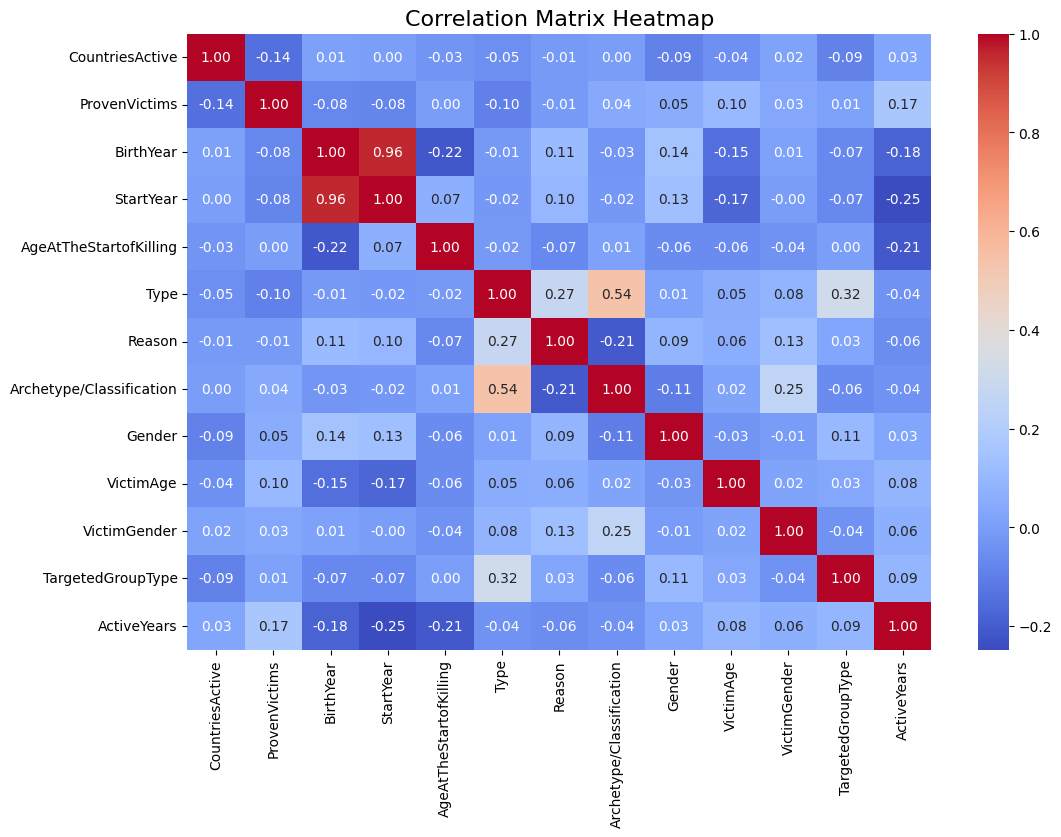

In [695]:
plt.figure(figsize=(12, 8))  
sns.heatmap(correlation_matrix, 
            annot=True,        
            fmt=".2f",         
            cmap="coolwarm",  
            cbar=True)         
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

In [696]:
# Assesing archetypes
unique_archetypes = df_clean['Archetype/Classification'].unique()
print(unique_archetypes)

['Power/Control' 'Mission-Oriented (Hate-Crime/Targeted Groups)'
 'Hedonistic - Lust' 'Hedonistic' 'Power and Hedonistic' 'Visionary'
 'Hedonistic - Thrill' 'Hate Crime']


In [697]:
# Filtering rows where the updated value is 'Hedonistic'
hedonistic_rows = df_clean[df_clean['Archetype/Classification'] == 'Hedonistic']
hedonistic_rows

,CountriesActive,ProvenVictims,BirthYear,StartYear,AgeAtTheStartofKilling,Type,Reason,Archetype/Classification,Gender,VictimAge,VictimGender,TargetedGroupType,ActiveYears
6,Czech Republic,5,1891,1948,57.0,"Financial Motive, Rapist, Sexual Predator","Financial Gain, Sexual Assault",Hedonistic,Male,Adult,Male,Other/Unspecified,4.0
9,Czech Republic,5,1891,1948,57.0,Financial Motive,Financial Gain,Hedonistic,Male,Adult,Male,Other/Unspecified,4.0
12,Belgium,11,1879,1933,54.0,Unknown,Financial Gain,Hedonistic,Male,Adult,Mixed,Other/Unspecified,4.0
16,Austria,3,1931,1981,50.0,"Financial Motive, Medical",Financial Gain,Hedonistic,Male,Adult,Mixed,Other/Unspecified,15.0
22,Russia,13,1947,1995,48.0,Cannibal,Cannibalism,Hedonistic,Female,Adult,Male,Other/Unspecified,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,United States,6,1947,1961,14.0,Cannibal,Cannibalism,Hedonistic,Male,Adult,Mixed,Other/Unspecified,23.0
514,Brazil,71,1954,1967,13.0,"Cannibal, Cannibal, Torturer",Cannibalism,Hedonistic,Male,Adult,Mixed,Other/Unspecified,37.0
527,Russia,14,1910,1945,35.0,Financial Motive,Financial Gain,Hedonistic,Male,Adult,Mixed,Other/Unspecified,2.0
550,China,11,1956,2008,52.0,"Cannibal, Cannibal, Strangler",Cannibalism,Hedonistic,Male,Adult,Mixed,Other/Unspecified,5.0


In [698]:
# Renaming archetypes to match the 4 relevant types mentioned in our research
df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Hedonistic - Lust', 'Hedonistic')
df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Hedonistic - Thrill', 'Hedonistic')
df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Profit Killer', 'Hedonistic')
df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Hate Crime', 'Missionary')
df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Mission-Oriented (Hate-Crime/Targeted Groups)', 'Missionary')


# Verifying the change
unique_archetypes = df_clean['Archetype/Classification'].unique()
print(unique_archetypes)


['Power/Control' 'Missionary' 'Hedonistic' 'Power and Hedonistic'
 'Visionary']


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\1325119903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Hedonistic - Lust', 'Hedonistic')
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\1325119903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Hedonistic - Thrill', 'Hedonistic')
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\13

In [699]:

# Filtering rows where the updated value is 'Hedonistic'
hedonistic_rows = df_clean[df_clean['Archetype/Classification'] == 'Power/Control']
hedonistic_rows

# Remove 'Hate Crime,' from the 'Type' column
df_clean['Type'] = df_clean['Type'].str.replace('Hate Crime, Medical', 'Medical', regex=False).str.strip()

# Verify the change
print(df_clean['Type'].unique())



['Unknown' 'Hate Crime' 'Hate Crime, Rapist, Sexual Predator'
 'Financial Motive, Rapist, Sexual Predator' 'Rapist, Sexual Predator'
 'Financial Motive' 'Torturer'
 'Cannibal, Pedophile, Rapist, Vampire, Cannibal, Torturer, Stalker, Sexual Predator, Vampire'
 'Financial Motive, Medical' 'Rapist, Stalker, Sexual Predator'
 'Rapist, Necrophiliac, Strangler, Sexual Predator'
 'Rapist, Strangler, Sexual Predator' 'Cannibal' 'Hate Crime, Strangler'
 'Rapist, Strangler, Pedophile, Sexual Predator'
 'Rapist, Torturer, Strangler, Sexual Predator' 'Sexual Predator'
 'Rapist, Pedophile, Strangler, Sexual Predator'
 'Financial Motive, Hate Crime'
 'Financial Motive, Medical, Rapist, Torturer, Sexual Predator'
 'Financial Motive, Rapist, Torturer, Strangler, Sexual Predator'
 'Cannibal, Necrophiliac, Cannibal, Rapist, Sexual Predator'
 'Serial Killer, Rapist, Strangler, Vampire, Sexual Predator, Vampire'
 'Rapist, Torturer, Sexual Predator'
 'Rapist, Torturer, Strangler, Stalker, Sexual Predator'


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2191764631.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Type'] = df_clean['Type'].str.replace('Hate Crime, Medical', 'Medical', regex=False).str.strip()


In [700]:
# Filter rows where the updated value is 'Hedonistic'
hedonistic_rows = df_clean[df_clean['Archetype/Classification'] == 'Power and Hedonistic']
df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Power and Hedonistic', 'Power/Control')
df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Power', 'Power/Control')
# Filter rows where the updated value is 'Hedonistic'
hedonistic_rows = df_clean[df_clean['Archetype/Classification'] == 'Visionary']
hedonistic_rows


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\1521671907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Power and Hedonistic', 'Power/Control')
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\1521671907.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Power', 'Power/Control')


,CountriesActive,ProvenVictims,BirthYear,StartYear,AgeAtTheStartofKilling,Type,Reason,Archetype/Classification,Gender,VictimAge,VictimGender,TargetedGroupType,ActiveYears
49,Canada,4,1920,1963,43.0,Unknown,Mental Illness,Visionary,Male,Adult,Male,Other/Unspecified,1.0
130,United Kingdom,6,1909,1944,35.0,Vampire,Religious,Visionary,Male,Adult,Mixed,Other/Unspecified,6.0
150,United States,6,1962,1996,34.0,Visionary,Mental Illness,Visionary,Male,Adult,Mixed,Elderly,2.0
310,United States,4,1955,1981,26.0,Unknown,Religious,Visionary,Male,Child,Mixed,Other/Unspecified,6.0
320,United States,13,1947,1972,25.0,Unknown,Mental Illness,Visionary,Male,Adult,Male,Other/Unspecified,2.0
387,United Kingdom,5,1865,1888,23.0,Unknown,Mental Illness,Visionary,Male,Adult,Mixed,Other/Unspecified,4.0
538,Russia,13,1956,2004,48.0,Unknown,Mental Illness,Visionary,Male,Adult,Male,Other/Unspecified,3.0
573,Colombia,7,1971,2002,31.0,Unknown,Occult Ritual,Visionary,Male,Adult,Mixed,Other/Unspecified,17.0


In [701]:

# Verify the change
unique_archetypes = df_clean['Archetype/Classification'].unique()
print(unique_archetypes)
hedonistic_rows = df_clean[df_clean['Archetype/Classification'] == 'Power/Control - Lust']
hedonistic_rows
df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Power/Control - Lust', 'Power/Control')
# Verify the change
unique_archetypes = df_clean['Archetype/Classification'].unique()
print(unique_archetypes)



['Power/Control' 'Missionary' 'Hedonistic' 'Visionary']
['Power/Control' 'Missionary' 'Hedonistic' 'Visionary']


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2518746389.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Archetype/Classification'] = df_clean['Archetype/Classification'].replace('Power/Control - Lust', 'Power/Control')


### Logistic Regression

In [715]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Preparing the data

# Define the columns to keep
selected_columns = ["CountriesActive", "AgeAtTheStartofKilling",
                    "Reason", "Archetype/Classification", "Gender", "VictimAge", 
                    "VictimGender", "TargetedGroupType", "ProvenVictims"]

# Create a subset of df_regression_cleaned with only the selected columns
df_regression_limited = df_clean[selected_columns].copy()

# Ensure all columns with lists are converted to strings
columns_with_lists = ['CountriesActive', 'Reason', 'Gender', 'VictimGender', 'TargetedGroupType', 'VictimAge']
for col in columns_with_lists:
    df_regression_limited[col] = df_regression_limited[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

# Encode the target column `Archetype/Classification` with LabelEncoder
label_encoder = LabelEncoder()
df_regression_limited['Archetype/Classification'] = label_encoder.fit_transform(df_regression_limited['Archetype/Classification'])

# Label-encode remaining categorical columns to ensure all data is numeric
for col in ['VictimAge', 'CountriesActive', 'Reason', 'Gender', 'VictimGender', 'TargetedGroupType']:
    if df_regression_limited[col].dtype == 'object':
        le = LabelEncoder()
        df_regression_limited[col] = le.fit_transform(df_regression_limited[col])

# Define features (X) and target (y)
X = df_regression_limited.drop(columns=['Archetype/Classification'])
y = df_regression_limited['Archetype/Classification']

# Split data into training (80%) and remaining (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Divide the remaining 20% equally into test and validation sets (10% each of the total data)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of each dataset to confirm
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Logistic Regression with class balancing
log_reg = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Predictions
train_predictions = log_reg.predict(X_train_scaled)
test_predictions = log_reg.predict(X_test_scaled)
val_predictions = log_reg.predict(X_val_scaled)

# Performance Metrics Function for Classification
def print_classification_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{dataset_name} Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Macro F1 Score: {macro_f1:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\n")

# Print Metrics
print_classification_metrics(y_train, train_predictions, "Training")
print_classification_metrics(y_test, test_predictions, "Testing")
print_classification_metrics(y_val, val_predictions, "Validation")

# testing data
accuracy_lr = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy_lr:.2f}")




Training set size: 445
Testing set size: 56
Validation set size: 56
Training Performance:
Accuracy: 0.60
Macro F1 Score: 0.44

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       264
           1       0.19      0.93      0.31        14
           2       0.69      0.42      0.52       161
           3       0.09      1.00      0.16         6

    accuracy                           0.60       445
   macro avg       0.46      0.76      0.44       445
weighted avg       0.77      0.60      0.66       445


Confusion Matrix:
[[182  23  30  29]
 [  0  13   1   0]
 [ 26  33  68  34]
 [  0   0   0   6]]


Testing Performance:
Accuracy: 0.59
Macro F1 Score: 0.43

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75        33
           1       0.25      1.00      0.40         2
           2       0.67      0.50      0.57        20
           3       

#### Random Forest

Random Forest is an algorythm used for classification and regression tasks. It handles both numerical and categorical data, fitting our dataset best. We decided it would work best when classifying serial killers into predefined archetypes accurately.

In [703]:
# Importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Preparing the data
# Encoding the target column (Archetype/Classification) and features
df_encoded = df_clean.copy()

# Label encoding categorical columns (features)
label_encoder = LabelEncoder()
for column in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column].astype(str))

# Defining the features (X) and target variable (y)
X = df_encoded.drop(columns=['Archetype/Classification'])  
y = df_encoded['Archetype/Classification']  

# Splitting the data into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting temp into test (10%) and validation (10%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Checking the sizes of the splits
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
print("Validation set size:", len(X_val))

# Initializing the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Tracking the accuracy
num_trees = [10, 50, 100, 200]  # Number of trees in each iteration
train_accuracies = []
test_accuracies = []

# Training loop
for n in num_trees:
    print(f"\nTraining Random Forest with {n} trees...")
    
    # Updating the model with the current number of trees
    rf_model.set_params(n_estimators=n)
    
    # Training the model
    rf_model.fit(X_train, y_train)
    
    # Predicting on the training set and test set
    train_predictions = rf_model.predict(X_train)
    test_predictions = rf_model.predict(X_test)
    
    # Calculating accuracy
    train_acc = accuracy_score(y_train, train_predictions)
    test_acc = accuracy_score(y_test, test_predictions)
    
    # Saving the accuracies
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy: {test_acc:.2f}")

# Predicting on the validation set
validation_predictions = rf_model.predict(X_val)

# Calculating accuracy
validation_accuracy_RF = accuracy_score(y_val, validation_predictions)
print(f"\nFinal Validation Accuracy: {validation_accuracy_RF:.2f}")

Training set size: 445
Testing set size: 56
Validation set size: 56

Training Random Forest with 10 trees...
Train Accuracy: 1.00
Test Accuracy: 0.96

Training Random Forest with 50 trees...
Train Accuracy: 1.00
Test Accuracy: 0.96

Training Random Forest with 100 trees...
Train Accuracy: 1.00
Test Accuracy: 0.96

Training Random Forest with 200 trees...
Train Accuracy: 1.00
Test Accuracy: 0.96

Final Validation Accuracy: 0.98


Random Forest Performance (10 trees):
Training Accuracy: 1.00
Test Accuracy: 0.96
Validation Accuracy: 0.95


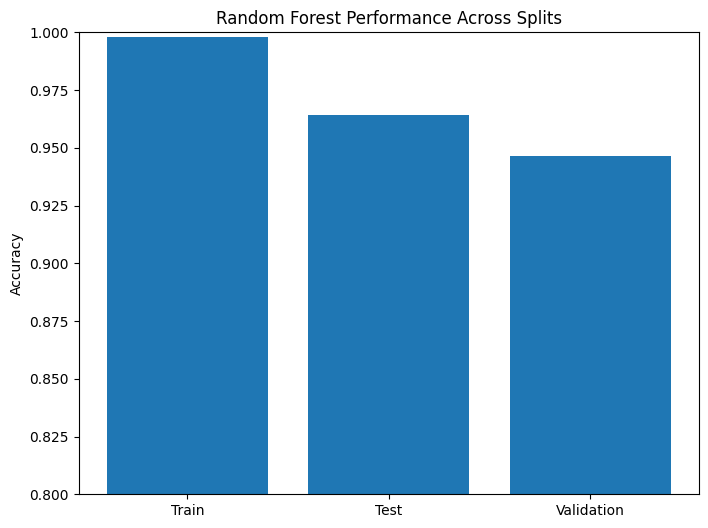

In [704]:
# Initialize best model (10 trees since all performed equally)
best_rf = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the model
best_rf.fit(X_train, y_train)

# Make predictions on all sets
train_pred_rf = best_rf.predict(X_train)
test_pred_rf = best_rf.predict(X_test)
val_pred_rf = best_rf.predict(X_val)

# Calculate accuracies
train_accuracy_rf = accuracy_score(y_train, train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, test_pred_rf)
val_accuracy_rf = accuracy_score(y_val, val_pred_rf)

# Print results
print("Random Forest Performance (10 trees):")
print(f"Training Accuracy: {train_accuracy_rf:.2f}")
print(f"Test Accuracy: {test_accuracy_rf:.2f}")
print(f"Validation Accuracy: {val_accuracy_rf:.2f}")

# Optional: Plot results
plt.figure(figsize=(8, 6))
accuracies = [train_accuracy_rf, test_accuracy_rf, val_accuracy_rf]
splits = ['Train', 'Test', 'Validation']
plt.bar(splits, accuracies)
plt.ylim(0.8, 1.0)  # Adjusted for better visualization
plt.title('Random Forest Performance Across Splits')
plt.ylabel('Accuracy')
plt.show()

Feature Importance:
Type: 0.4991
Reason: 0.3089
ProvenVictims: 0.0400
BirthYear: 0.0263
AgeAtTheStartofKilling: 0.0226
StartYear: 0.0213
CountriesActive: 0.0205
VictimGender: 0.0192
ActiveYears: 0.0169
TargetedGroupType: 0.0135
Gender: 0.0075
VictimAge: 0.0040


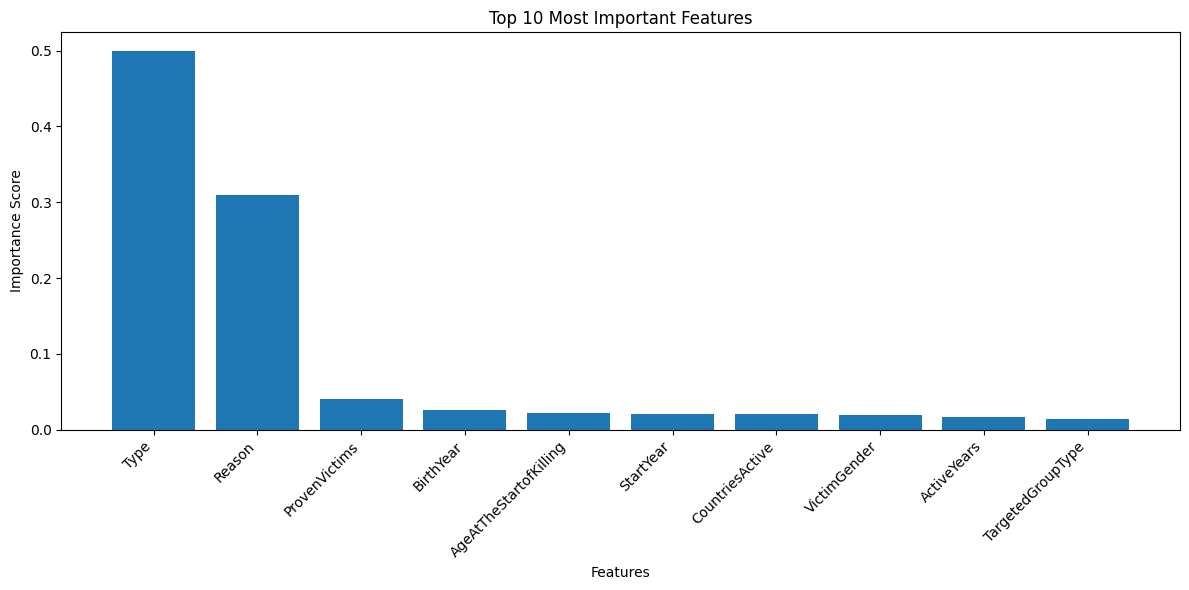

In [705]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Calculate and display feature importance percentages
total_importance = feature_importance['importance'].sum()
feature_importance['importance_percentage'] = feature_importance['importance'] / total_importance

# Print feature importance
print("Feature Importance:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance_percentage']:.4f}")

# Visualize top 10 features
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance_percentage'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

### Gradient Boosted Tree

In [706]:
# Preparing the data
# Encoding the target column (Archetype/Classification) and features
df_encode_GB = df_clean.copy()

# Label encoding categorical columns (features)
label_encoder = LabelEncoder()
for column in df_encode_GB.select_dtypes(include=['object']).columns:
    df_encode_GB[column] = label_encoder.fit_transform(df_encode_GB[column].astype(str))

# Dropping the 'Victim Age' column as it does not contribute to model performance
df_encode_GB = df_encode_GB.drop(columns=['Gender', 'VictimAge'])

# Defining the features (X) and target variable (y)
X_GB = df_encode_GB.drop(columns=['Archetype/Classification'])  
y_GB = df_encode_GB['Archetype/Classification']  

# Splitting the data into train (80%) and temp (20%)
X_train_GB, X_temp_GB, y_train_GB, y_temp_GB = train_test_split(X_GB, y_GB, test_size=0.2, random_state=42)

# Splitting temp into test (10%) and validation (10%)
X_test_GB, X_val_GB, y_test_GB, y_val_GB = train_test_split(X_temp_GB, y_temp_GB, test_size=0.5, random_state=42)

# Checking the sizes of the splits
print("Training set size:", len(X_train_GB))
print("Testing set size:", len(X_test_GB))
print("Validation set size:", len(X_val_GB))

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


# Initializing the Gradient Boosted Tree model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Load the model
xgb_model.fit(X_train_GB, y_train_GB)

# Predicting on the validation set
validation_predictions_GB = xgb_model.predict(X_val_GB)

# Calculating accuracy for training set
train_predictions_GB = xgb_model.predict(X_train_GB) 
train_accuracy_GB = accuracy_score(y_train_GB, train_predictions_GB)    
print(f"\Train Accuracy: {train_accuracy_GB:.2f}")

# Calculating accuracy
validation_accuracy_GB = accuracy_score(y_val_GB, validation_predictions_GB)
print(f"\Validation Accuracy: {validation_accuracy_GB:.2f}")


# Analyzing feature importance
importances_GB = xgb_model.feature_importances_
feature_importance_GB = sorted(zip(X_GB.columns, importances_GB), key=lambda x_GB: x_GB[1], reverse=True)

print("\nFeature Importance:")
for feature_GB, importance_GB in feature_importance_GB:
    print(f"{feature_GB}: {importance_GB:.4f}")


Training set size: 445
Testing set size: 56
Validation set size: 56
\Train Accuracy: 1.00
\Validation Accuracy: 0.98

Feature Importance:
Type: 0.6442
Reason: 0.1984
ActiveYears: 0.0334
AgeAtTheStartofKilling: 0.0283
CountriesActive: 0.0269
ProvenVictims: 0.0175
BirthYear: 0.0167
TargetedGroupType: 0.0138
StartYear: 0.0119
VictimGender: 0.0089


<>:43: SyntaxWarning: invalid escape sequence '\T'
<>:47: SyntaxWarning: invalid escape sequence '\V'
<>:43: SyntaxWarning: invalid escape sequence '\T'
<>:47: SyntaxWarning: invalid escape sequence '\V'
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\1938885350.py:43: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Train Accuracy: {train_accuracy_GB:.2f}")
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\1938885350.py:47: SyntaxWarning: invalid escape sequence '\V'
  print(f"\Validation Accuracy: {validation_accuracy_GB:.2f}")


In [707]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Setting up the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setting up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fitting the model
grid_search.fit(X_train_GB, y_train_GB)

# Best parameters and best score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluating the best model on the validation set
best_model_GB = grid_search.best_estimator_
validation_predictions_GB = best_model_GB.predict(X_val_GB)
validation_accuracy_GB = accuracy_score(y_val_GB, validation_predictions_GB)
print(f"\nFinal Validation Accuracy: {validation_accuracy_GB:.2f}")

# Analyzing feature importance
importances_GB = best_model_GB.feature_importances_
feature_importance_GB = sorted(zip(X_GB.columns, importances_GB), key=lambda x_GB: x_GB[1], reverse=True)

print("\nFeature Importance:")
for feature_GB, importance_GB in feature_importance_GB:
    print(f"{feature_GB}: {importance_GB:.4f}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.9730334361206845

Final Validation Accuracy: 0.98

Feature Importance:
Type: 0.5519
Reason: 0.2255
VictimGender: 0.0412
ProvenVictims: 0.0315
BirthYear: 0.0282
ActiveYears: 0.0279
CountriesActive: 0.0273
AgeAtTheStartofKilling: 0.0255
TargetedGroupType: 0.0221
StartYear: 0.0190


In [708]:
# Suppressing specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Evaluating the model on the test set
test_predictions_GB = best_model_GB.predict(X_test_GB)
test_accuracy_GB = accuracy_score(y_test_GB, test_predictions_GB)
print(f"\nFinal Test Accuracy: {test_accuracy_GB:.2f}")

# Error Analysis
print("\nClassification Report:")
print(classification_report(y_test_GB, test_predictions_GB))

# Extracting feature names from feature_importance
features_GB = [feature_GB for feature_GB, importance_GB in feature_importance_GB]

# Summary of Findings
summary_GB = f'''
Model Performance Summary:
- Best Hyperparameters: {grid_search.best_params_}
- Validation Accuracy: {validation_accuracy_GB:.2f}
- Test Accuracy: {test_accuracy_GB:.2f}

Error Analysis:
- See Classification Report for detailed insights.

Feature Importance:
- Top Features:
  {', '.join(features_GB[:5])}
'''
print(summary_GB)



Final Test Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00         2
           2       0.95      1.00      0.98        20
           3       0.00      0.00      0.00         1

    accuracy                           0.98        56
   macro avg       0.74      0.75      0.74        56
weighted avg       0.97      0.98      0.97        56


Model Performance Summary:
- Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
- Validation Accuracy: 0.98
- Test Accuracy: 0.98

Error Analysis:
- See Classification Report for detailed insights.

Feature Importance:
- Top Features:
  Type, Reason, VictimGender, ProvenVictims, BirthYear



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Neural Network

In [709]:
# Preparing the data
df_nn = df_clean.copy()

# Encode categorical columns (features and target)
label_encoder = LabelEncoder()
for column in df_nn.select_dtypes(include=['object']).columns:
    df_nn[column] = label_encoder.fit_transform(df_nn[column].astype(str))

# Separate features and target
X_nn = df_nn.drop(columns=['Archetype/Classification'])  # Features
y_nn = df_nn['Archetype/Classification']  # Target

# Use SMOTE to balance the dataset 
smote = SMOTE(random_state=42, k_neighbors=1, sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(X_nn, y_nn)

# Scaling the features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Splitting the balanced and scaled data into train, temp (test + validation)
X_train_nn, X_temp_nn, y_train_nn, y_temp_nn = train_test_split(
    X_resampled_scaled, y_resampled,
    test_size=0.2, 
    random_state=42,
    stratify=y_resampled # Maintain the class distribution
)

# Splitting temp into test and validation
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(
    X_temp_nn, y_temp_nn,
    test_size=0.5,  # Split the temp set equally into test and validation
    random_state=42,
    stratify=y_temp_nn 
)

y_train_nn_encoded, y_val_nn_encoded, y_test_nn_encoded = encode_target(y_train_nn, y_val_nn, y_test_nn)

# Building the Neural Network
def create_nn_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential([
        Dense(128, input_dim=X_train_nn.shape[1], activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(y_train_nn_encoded.shape[1], activation='softmax')  # Output layer matches the number of classes
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class
                  metrics=['accuracy'])
    return model

# Initialize and train the model
nn_model = create_nn_model(learning_rate=0.001, dropout_rate=0.3)

history = nn_model.fit(
    X_train_nn, y_train_nn_encoded,  # Use one-hot encoded labels for training
    validation_data=(X_val_nn, y_val_nn_encoded),  # Use one-hot encoded labels for validation
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3949 - loss: 1.3736 - val_accuracy: 0.7752 - val_loss: 0.9334
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7304 - loss: 0.8997 - val_accuracy: 0.8372 - val_loss: 0.6045
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8017 - loss: 0.6715 - val_accuracy: 0.8760 - val_loss: 0.4285
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8328 - loss: 0.5193 - val_accuracy: 0.8682 - val_loss: 0.3455
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8541 - loss: 0.4401 - val_accuracy: 0.8837 - val_loss: 0.2958
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8864 - loss: 0.3618 - val_accuracy: 0.9225 - val_loss: 0.2530
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8925 - loss: 0.3446 - val_accuracy: 0.9380 - val_loss: 0.2256
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8968 - loss: 0.3408 - val_accuracy: 0.9457 - val_loss: 0.2118
Epo


Neural Network Test Accuracy: 0.98


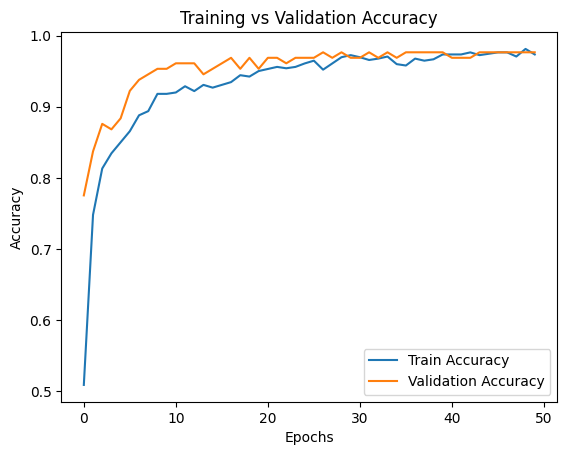

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


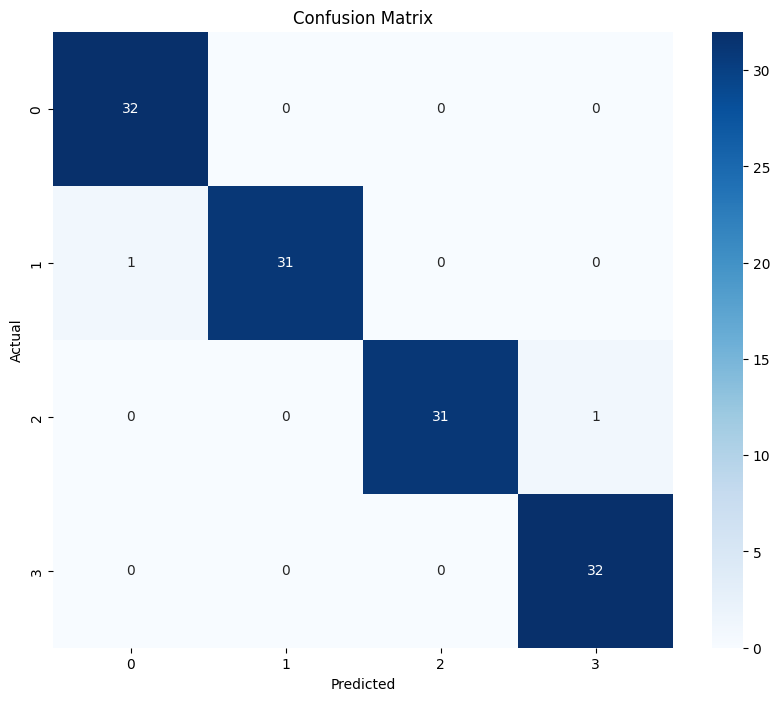

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.97      0.98        32
           2       1.00      0.97      0.98        32
           3       0.97      1.00      0.98        32

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128

Top Important Features:
                   Feature  Importance
6                   Reason    0.373437
5                     Type    0.343750
9             VictimGender    0.266406
10       TargetedGroupType    0.100781
3                StartYear    0.088281
0          CountriesActive    0.078125
4   AgeAtTheStartofKilling    0.071875
2                BirthYear    0.044531
11             ActiveYears    0.036719
8                VictimAge    0.032031


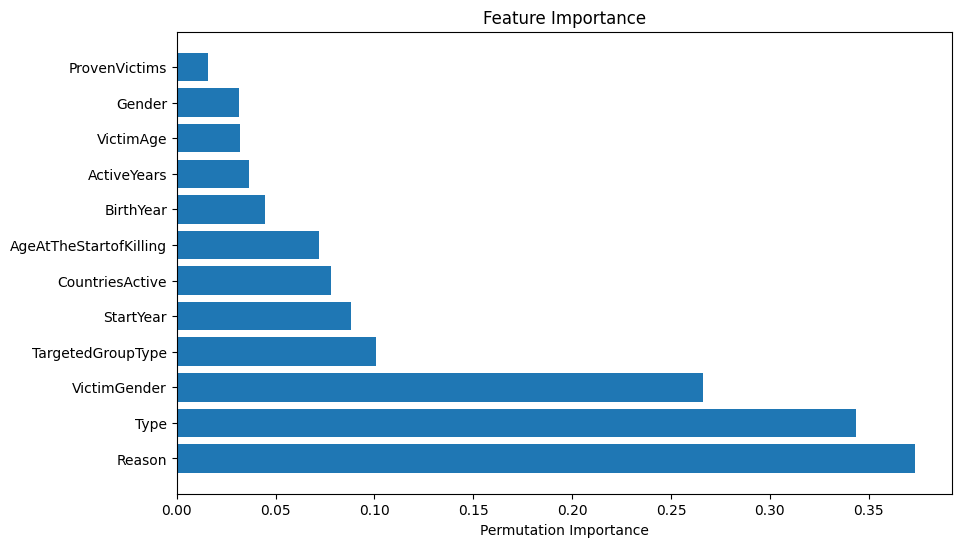

In [710]:

# Evaluate the model on the test set
test_loss_nn, test_accuracy_nn = nn_model.evaluate(X_test_nn, y_test_nn_encoded, verbose=0)
print(f"\nNeural Network Test Accuracy: {test_accuracy_nn:.2f}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Confusion Matrix
nn_test_predictions = np.argmax(nn_model.predict(X_test_nn), axis=1)
conf_matrix = confusion_matrix(y_test_nn, nn_test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(nn_test_predictions), yticklabels=np.unique(nn_test_predictions))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_nn, nn_test_predictions))

# Permutation Feature Importance
def keras_accuracy(model, X, y):
    y_pred = model.predict(X, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return accuracy_score(y, y_pred_classes)

perm_importance = permutation_importance(
    nn_model, 
    X_test_nn, 
    y_test_nn, 
    n_repeats=10, 
    random_state=42, 
    scoring=keras_accuracy
)

# Summarize and plot the importance
importance_df = pd.DataFrame({
    'Feature': X_nn.columns,  # Feature names
    'Importance': perm_importance.importances_mean 
}).sort_values(by='Importance', ascending=False)

# Print out the top important features
print("Top Important Features:")
print(importance_df[['Feature', 'Importance']].head(10))  # Top 10 important features

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

In [711]:
# Feature selection based on importance
selected_features = importance_df[importance_df['Importance'] > 0.01]['Feature']
X_nn_selected = X_nn[selected_features]  # Select only the top important features

# Scaling and splitting data
scaler = StandardScaler()
X_nn_selected_scaled = scaler.fit_transform(X_nn_selected)

X_train_sel, X_temp_sel, y_train_sel, y_temp_sel = train_test_split(
    X_nn_selected_scaled, y_nn, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_nn
)

X_test_sel, X_val_sel, y_test_sel, y_val_sel = train_test_split(
    X_temp_sel, y_temp_sel, 
    test_size=0.5,  
    random_state=42, 
    stratify=y_temp_sel
)

# One-hot encode for training, validation, and testing sets
y_train_sel_encoded, y_val_sel_encoded, y_test_sel_encoded = encode_target(y_train_sel, y_val_sel, y_test_sel)


# Define a model for the selected features
def create_nn_model(learning_rate=0.001, dropout_rate=0.3, input_dim=X_train_sel.shape[1], num_classes=NUM_CLASSES): 
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'), 
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')  # Output layer matches the number of classes
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class
                  metrics=['accuracy'])
    return model

# Initialize and train the model
nn_model_selected = create_nn_model(learning_rate=0.001, dropout_rate=0.3, input_dim=X_train_sel.shape[1], num_classes=NUM_CLASSES)
history_selected = nn_model_selected.fit(
    X_train_sel, y_train_sel_encoded, 
    validation_data=(X_val_sel, y_val_sel_encoded), 
    epochs=50,
    batch_size=32,
    verbose=1
)

# Final evaluation with refined features
test_loss_sel_nn, test_accuracy_sel_nn = nn_model_selected.evaluate(X_test_sel, y_test_sel, verbose=0)


Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5718 - loss: 1.1288 - val_accuracy: 0.6964 - val_loss: 0.8772
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7262 - loss: 0.8475 - val_accuracy: 0.8393 - val_loss: 0.6742
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8158 - loss: 0.6227 - val_accuracy: 0.8571 - val_loss: 0.5776
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8558 - loss: 0.5596 - val_accuracy: 0.8571 - val_loss: 0.5262
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8311 - loss: 0.5768 - val_accuracy: 0.8571 - val_loss: 0.4851
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8808 - loss: 0.4482 - val_accuracy: 0.8750 - val_loss: 0.4626
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8684 - loss: 0.4271 - val_accuracy: 0.8929 - val_loss: 0.4537
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8998 - loss: 0.3660 - val_accuracy: 0.8929 - val_loss: 0.4405
Ep

In [712]:
print(f"\nRefined Neural Network Test Accuracy: {test_accuracy_sel_nn:.2f}")


Refined Neural Network Test Accuracy: 0.96


### Comparing all the Results

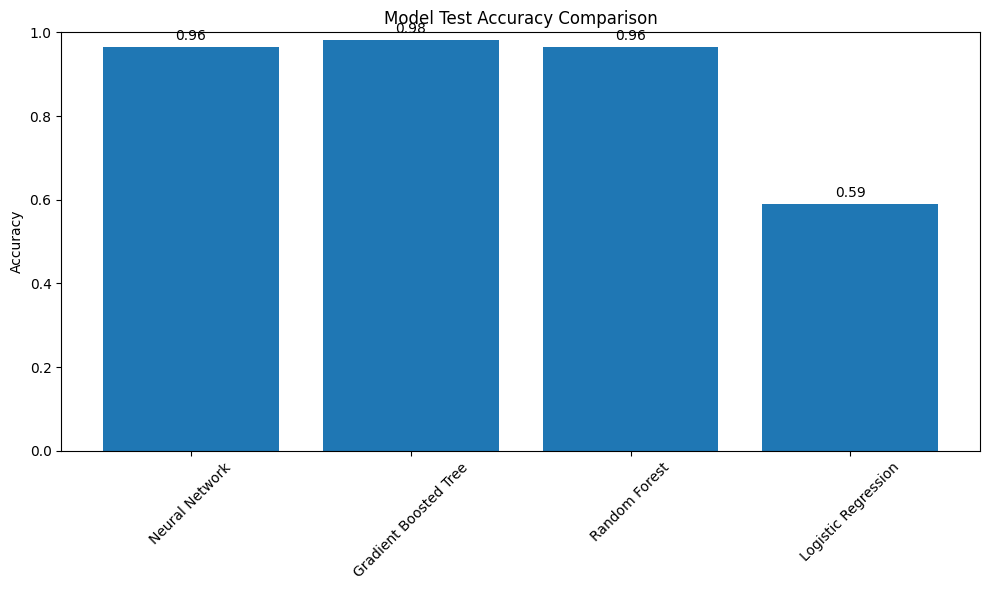


Test Accuracy Comparison:
Neural Network       Test Accuracy: 0.96
Gradient Boosted Tree Test Accuracy: 0.98
Random Forest        Test Accuracy: 0.96
Logistic Regression  Test Accuracy: 0.59


In [716]:
def compare_test_accuracies():
    # Store accuracies
    accuracies = {
        'Neural Network': test_accuracy_sel_nn,
        'Gradient Boosted Tree': test_accuracy_GB,
        'Random Forest': test_accuracy_rf,
        'Logistic Regression': accuracy_lr  # From classification metrics
    }
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.ylim(0, 1.0)
    plt.title('Model Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # Add value labels
    for i, (model, acc) in enumerate(accuracies.items()):
        plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nTest Accuracy Comparison:")
    for model, acc in accuracies.items():
        print(f"{model:20} Test Accuracy: {acc:.2f}")

# Execute comparison
compare_test_accuracies()

#### Conclusion
Gradient Boosted Tree with a learning rate of 0.2 proved to be the model that was able to classify the samples into 4 categories with the highest accuracy rate of 0.98. However, a Random Forest with (?) trees as well as a FeedForward Neural Network also achieved high accuracy levels with a score of 0.96. As such, all these models could be used to profile serial killers into categories that would help with figuring out potential suspects and behaviours to look for.